In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv("data/Abalation_study_31_07_2023.csv")
df["coverage"] = df["coverage"].apply(
    lambda x: float(x)
)
df["validity"] = df["validity"].apply(
    lambda x: float(x.replace(",", "."))
)


In [4]:
dfs = []

attributes_to_normalize = ["coverage", "validity"]

for platform in df['platform'].unique():
  df_platform = df[df['platform'] == platform]
  for attr in attributes_to_normalize:
    min_cov = df_platform[attr].min()
    max_cov = df_platform[attr].max()
    delta = max_cov - min_cov
    df_platform[attr + "_norm"] = df_platform[attr].apply(
        # % increment with respect to the minimum
        # lambda x: ((x - min_cov) / min_cov) + 1

        # max-min normalization
        lambda x: (x - min_cov) / delta
    )
  dfs.append(df_platform)

df_all = pd.concat(dfs)
df_all.head(25)

/tmp/ipykernel_11055/1665259125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_platform[attr + "_norm"] = df_platform[attr].apply(
/tmp/ipykernel_11055/1665259125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_platform[attr + "_norm"] = df_platform[attr].apply(
/tmp/ipykernel_11055/1665259125.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,variant,platform,coverage,validity,coverage_norm,validity_norm
0,no input,C,127904.0,44.16,0.000000,1.000000
1,user input,C,137594.0,34.33,0.166226,0.000000
2,autoprompt,C,183322.0,39.38,0.950664,0.513733
3,no example,C,142280.0,35.40,0.246612,0.108850
4,Fuzz4All,C,186198.0,41.66,1.000000,0.745677
5,no input,C++,181095.0,51.71,0.000000,1.000000
6,user input,C++,188550.0,34.59,0.596591,0.244150
7,autoprompt,C++,191197.0,36.89,0.808419,0.345695
8,no example,C++,190642.0,29.06,0.764004,0.000000
9,Fuzz4All,C++,193591.0,42.19,1.000000,0.579691


['SUT', 'C', 'C++', 'SMT', 'GO', 'Java', 'Qiskit', 'Ablation Variant', 'no input', 'user input', 'autoprompt']


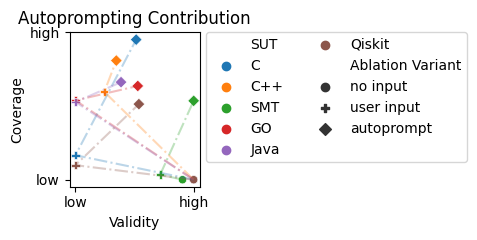

In [46]:
fig, ax = plt.subplots()

df_tmp = df_all.copy()

# keep autoprompt contrib
df_tmp = df_tmp[
    df_tmp["variant"].isin(
        # keep autoprompt contrib
        ['no input', 'user input', 'autoprompt']
        # keep others
        # ["no example", "Fuzz4All"]
)]


sns.scatterplot(
    data=df_tmp,
    x='validity_norm',
    y='coverage_norm',
    hue="platform",
    style="variant",
    markers=["o", "P", "D"],
    ax=ax
)

for platform, c in zip(df_tmp["platform"].unique(), sns.color_palette("tab10")):
  df_platform = df_tmp[df_tmp["platform"] == platform]
  # autoprompt contrib
  df_auto_platform = df_platform[df_platform['variant'].isin(
      ['no input', 'user input', 'autoprompt'])]
  ax.plot(
      df_auto_platform["validity_norm"],
      df_auto_platform["coverage_norm"],
      alpha=0.3,
      color=c,
      linestyle="-.",
      #label="autprompting contrib."
  )
  # fuzzy loop contrib
  df_fl_platform = df_platform[df_platform['variant'].isin(
      ["no example", "Fuzz4All"]
  )]
  ax.plot(
      df_fl_platform["validity_norm"],
      df_fl_platform["coverage_norm"],
      alpha=0.3,
      color=c,
      linestyle="--",
  )

# replace y labels with low and high coverage, at position 0 and 1
ax.set_yticks([0, 1])
ax.set_yticklabels(["low", "high"])
# same for x labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["low", "high"])
# set axis labels
ax.set_xlabel("Validity")
ax.set_ylabel("Coverage")

map_replacements = {
    "platform": "SUT",
    "variant": "Ablation Variant"
}

handles, labels = ax.get_legend_handles_labels()
labels = [map_replacements.get(label, label) for label in labels]
print(labels)

plt.legend(
  ncols=2,
  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
    handles=handles, labels=labels)

fig.set_size_inches(5, 2.5)
plt.title("Autoprompting Contribution")
plt.tight_layout()

plt.savefig("figures/ablation_study_ap_contrib.pdf", bbox_inches='tight')

/tmp/ipykernel_11055/2727038151.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_platform.sort_values(


['SUT', 'C', 'C++', 'SMT', 'GO', 'Java', 'Qiskit', 'Ablation Variant', 'gen-new only, w ex', 'gen-new only, w/o ex', 'all gens, w ex (Fuzz4All)']


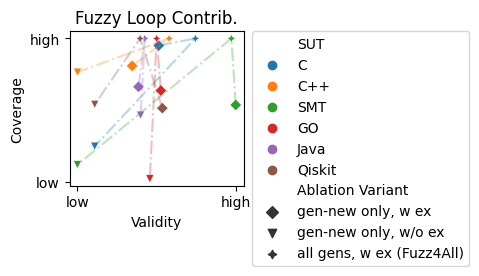

In [47]:
fig, ax = plt.subplots()

df_tmp = df_all.copy()

# fuzzy loo contrib
FILTER_AND_ORDER = ["autoprompt", "Fuzz4All", "no example"]

df_tmp = df_tmp[
    df_tmp["variant"].isin(FILTER_AND_ORDER)]


sns.scatterplot(
    data=df_tmp,
    x='validity_norm',
    y='coverage_norm',
    hue="platform",
    style="variant",
    markers=["D", "v", (4, 1, 0)],
    ax=ax
)

for platform, c in zip(df_tmp["platform"].unique(), sns.color_palette("tab10")):
  df_platform = df_tmp[df_tmp["platform"] == platform]
  df_platform.sort_values(
      by="variant", key=lambda column: column.map(lambda e: FILTER_AND_ORDER.index(e)), inplace=True)
  ax.plot(
      df_platform["validity_norm"],
      df_platform["coverage_norm"],
      alpha=0.3,
      color=c,
      linestyle="-.",
      #label="autprompting contrib."
  )

map_replacements = {
    "platform": "SUT",
    "variant": "Ablation Variant",
    "autoprompt": "gen-new only, w ex",
    "Fuzz4All": "all gens, w ex (Fuzz4All)",
    "no example": "gen-new only, w/o ex",
}

handles, labels = ax.get_legend_handles_labels()
labels = [map_replacements.get(label, label) for label in labels]
print(labels)
# set the new values

plt.legend(
  ncols=1, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
  handles=handles, labels=labels)

# replace y labels with low and high coverage, at position 0 and 1
ax.set_yticks([0, 1])
ax.set_yticklabels(["low", "high"])
# same for x labels
ax.set_xticks([0, 1])
ax.set_xticklabels(["low", "high"])
# set axis labels
ax.set_xlabel("Validity")
ax.set_ylabel("Coverage")


fig.set_size_inches(5, 2.5)
plt.title("Fuzzy Loop Contrib.")
plt.tight_layout()

plt.savefig("figures/ablation_study_fl_contrib.pdf", bbox_inches='tight')